# VAE MNIST INTERPOLATION OVER THE LATENT SPACE

In this notebook I load the best model from the training done in the `vae_mnist_training.ipynb` notebook and :
- I re-evaluate it on the test set to see if I manage to get the same result (I sometime struggle with seed...)
- I explore the latent space by interpolating between two points to see how the latent is structured.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split

from torch.utils.tensorboard import SummaryWriter

def loss(x, x_hat, q_z_given_x_mu, q_z_given_x_logvar):
    D_KL = -0.5 *(1 + q_z_given_x_logvar - q_z_given_x_mu.pow(2) - q_z_given_x_logvar.exp()).sum(dim=1)    
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='none').sum(dim=1)
    lower_bound = - BCE - D_KL
    return -lower_bound, BCE, D_KL

class BernoulliDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(BernoulliDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_size)
        self.activation = nn.Tanh()
        
    def forward(self, z):
        h = self.activation(self.fc1(z))
        h = self.fc2(h)
        x_hat = torch.sigmoid(h)
        return x_hat

    
class GaussianEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(GaussianEncoder, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size*2)
        self.tanh = nn.Tanh()

        
    def forward(self, x):
        h = self.tanh(self.fc1(x))
        h = self.fc2(h)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
    
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, device='cpu'):
        super(VAE, self).__init__()
        self.device = device
        self.encoder = GaussianEncoder(input_size, hidden_size, latent_size)
        self.decoder = BernoulliDecoder(input_size, hidden_size, latent_size)
        self.latent_size = latent_size

        self.to(device)
        
    def forward(self, x):
        q_z_given_x_mu, q_z_given_x_logvar = self.encoder(x)
        epsilon = torch.randn(q_z_given_x_mu.size()).to(self.device)
        z = q_z_given_x_mu + torch.exp(0.5 * q_z_given_x_logvar) * epsilon
        x_hat = self.decoder(z)
        return x_hat, q_z_given_x_mu, q_z_given_x_logvar
    
    def sample(self, num_samples):
        z = torch.randn((num_samples, self.latent_size)).to(self.device)
        x_hat = self.decoder(z)
        return x_hat
    
    def encode(self, x):
        q_z_given_x_mu, q_z_given_x_logvar = self.encoder(x)
        return q_z_given_x_mu, q_z_given_x_logvar
    
    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

generator = torch.Generator()
generator.manual_seed(seed)

cuda


In [3]:
batch_size = 100

transforms_mnist = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=transforms_mnist)
mnist_loader = DataLoader(dataset=mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=2,worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))

mnist_val_dataset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=transforms_mnist)

validation_split = 0.5
test_split = 1.0 - validation_split

total_size = len(mnist_val_dataset)
validation_size = int(total_size * validation_split)
test_size = total_size - validation_size

mnist_val_dataset, mnist_test_dataset = random_split(mnist_val_dataset, [validation_size, test_size], generator=generator)

mnist_val_loader = DataLoader(dataset=mnist_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
mnist_test_loader = DataLoader(dataset=mnist_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2,)

input_size = 28 * 28

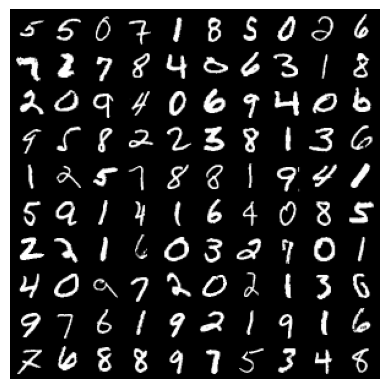

torch.Size([100, 1, 28, 28]) tensor(0.) tensor(1.)


In [4]:
# make a grid of images nrow x nrow
def make_grid(images, nrow=10):
    images = images.detach().cpu()
    grid = torchvision.utils.make_grid(images, nrow=nrow)
    return grid.permute(1, 2, 0)

def show(img):
    plt.imshow(img)
    plt.axis('off')

def show_images(images, nrow=10):
    grid = make_grid(images, nrow)
    show(grid)

# plot the first 64 images
images, _ = next(iter(mnist_val_loader))
show_images(images)
plt.show()
print(images.shape, images.min(), images.max())

In [8]:
# should be the same as in the training
hidden_size = 500
latent_size = 20
vae = VAE(input_size, hidden_size, latent_size, device)

best_path = 'best_mnist_vae_adam.pth'

try:
    vae.load_state_dict(torch.load(best_path))
    print('Loaded model')
except:
    print('Could not load model')

vae.eval()

Loaded model


/tmp/ipykernel_1355895/1352147883.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(best_path))


VAE(
  (encoder): GaussianEncoder(
    (fc1): Linear(in_features=784, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=40, bias=True)
    (tanh): Tanh()
  )
  (decoder): BernoulliDecoder(
    (fc1): Linear(in_features=20, out_features=500, bias=True)
    (fc2): Linear(in_features=500, out_features=784, bias=True)
    (activation): Tanh()
  )
)

Validation loss: 104.73475891113281 Validation BCE: 79.13408584594727 Validation KLD: 25.600674514770507
Test loss: 105.04357009887696 Test BCE: 79.38039138793945 Test KLD: 25.663177909851075


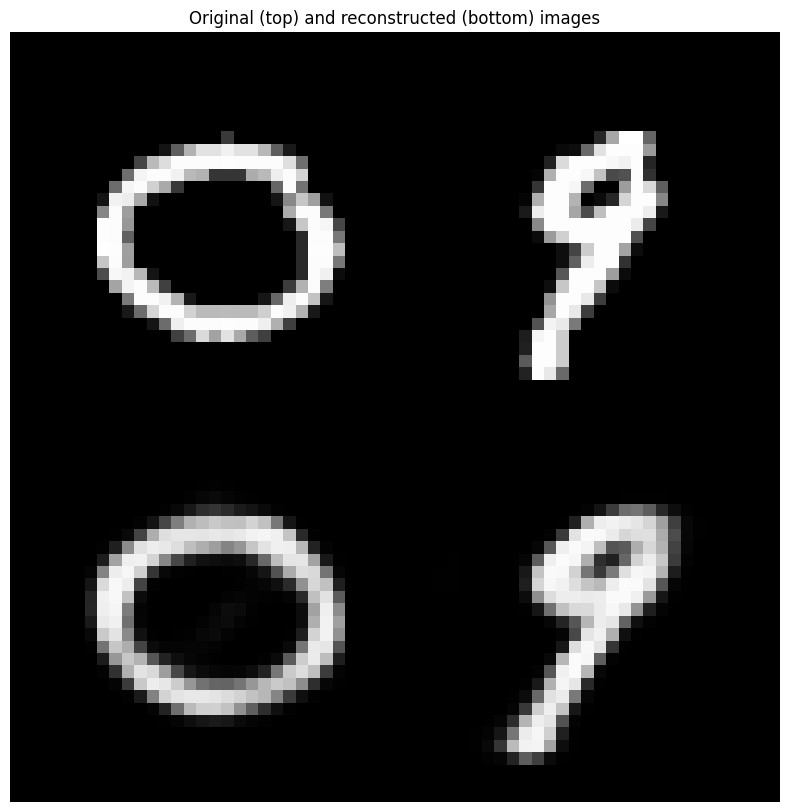

In [12]:
# evaluate the model on the validation set and compute the loss

def evaluate_model(vae, data_loader):
    total_loss = 0
    total_bce = 0
    total_kld = 0
    num_samples = 0
    for images, _ in data_loader:
        images = images.view(-1, input_size).to(device)
        x_hat, q_z_given_x_mu, q_z_given_x_logvar = vae(images)
        loss_val, bce, kld = loss(images, x_hat, q_z_given_x_mu, q_z_given_x_logvar)

        total_loss += loss_val.mean().item()
        total_bce += bce.mean().item()
        total_kld += kld.mean().item()

    return total_loss / len(data_loader), total_bce / len(data_loader), total_kld / len(data_loader)

val_loss, val_bce, val_kld = evaluate_model(vae, mnist_val_loader)
print('Validation loss:', val_loss, 'Validation BCE:', val_bce, 'Validation KLD:', val_kld)

# evaluate the model on the test set and compute the loss

test_loss, test_bce, test_kld = evaluate_model(vae, mnist_test_loader)
print('Test loss:', test_loss, 'Test BCE:', test_bce, 'Test KLD:', test_kld)

# sample two images from the test set and show the original and the reconstructed image

images, _ = next(iter(mnist_test_loader))
k = 5
images = images.view(-1, input_size).to(device)[k:k+2]
x_hat, _, _ = vae(images)

images = images.view(-1, 1, 28, 28)
x_hat = x_hat.view(-1, 1, 28, 28)

plt.figure(figsize=(10, 10))
plt.title('Original (top) and reconstructed (bottom) images')
show_images(torch.cat((images, x_hat), dim=0), nrow=2)
plt.show()

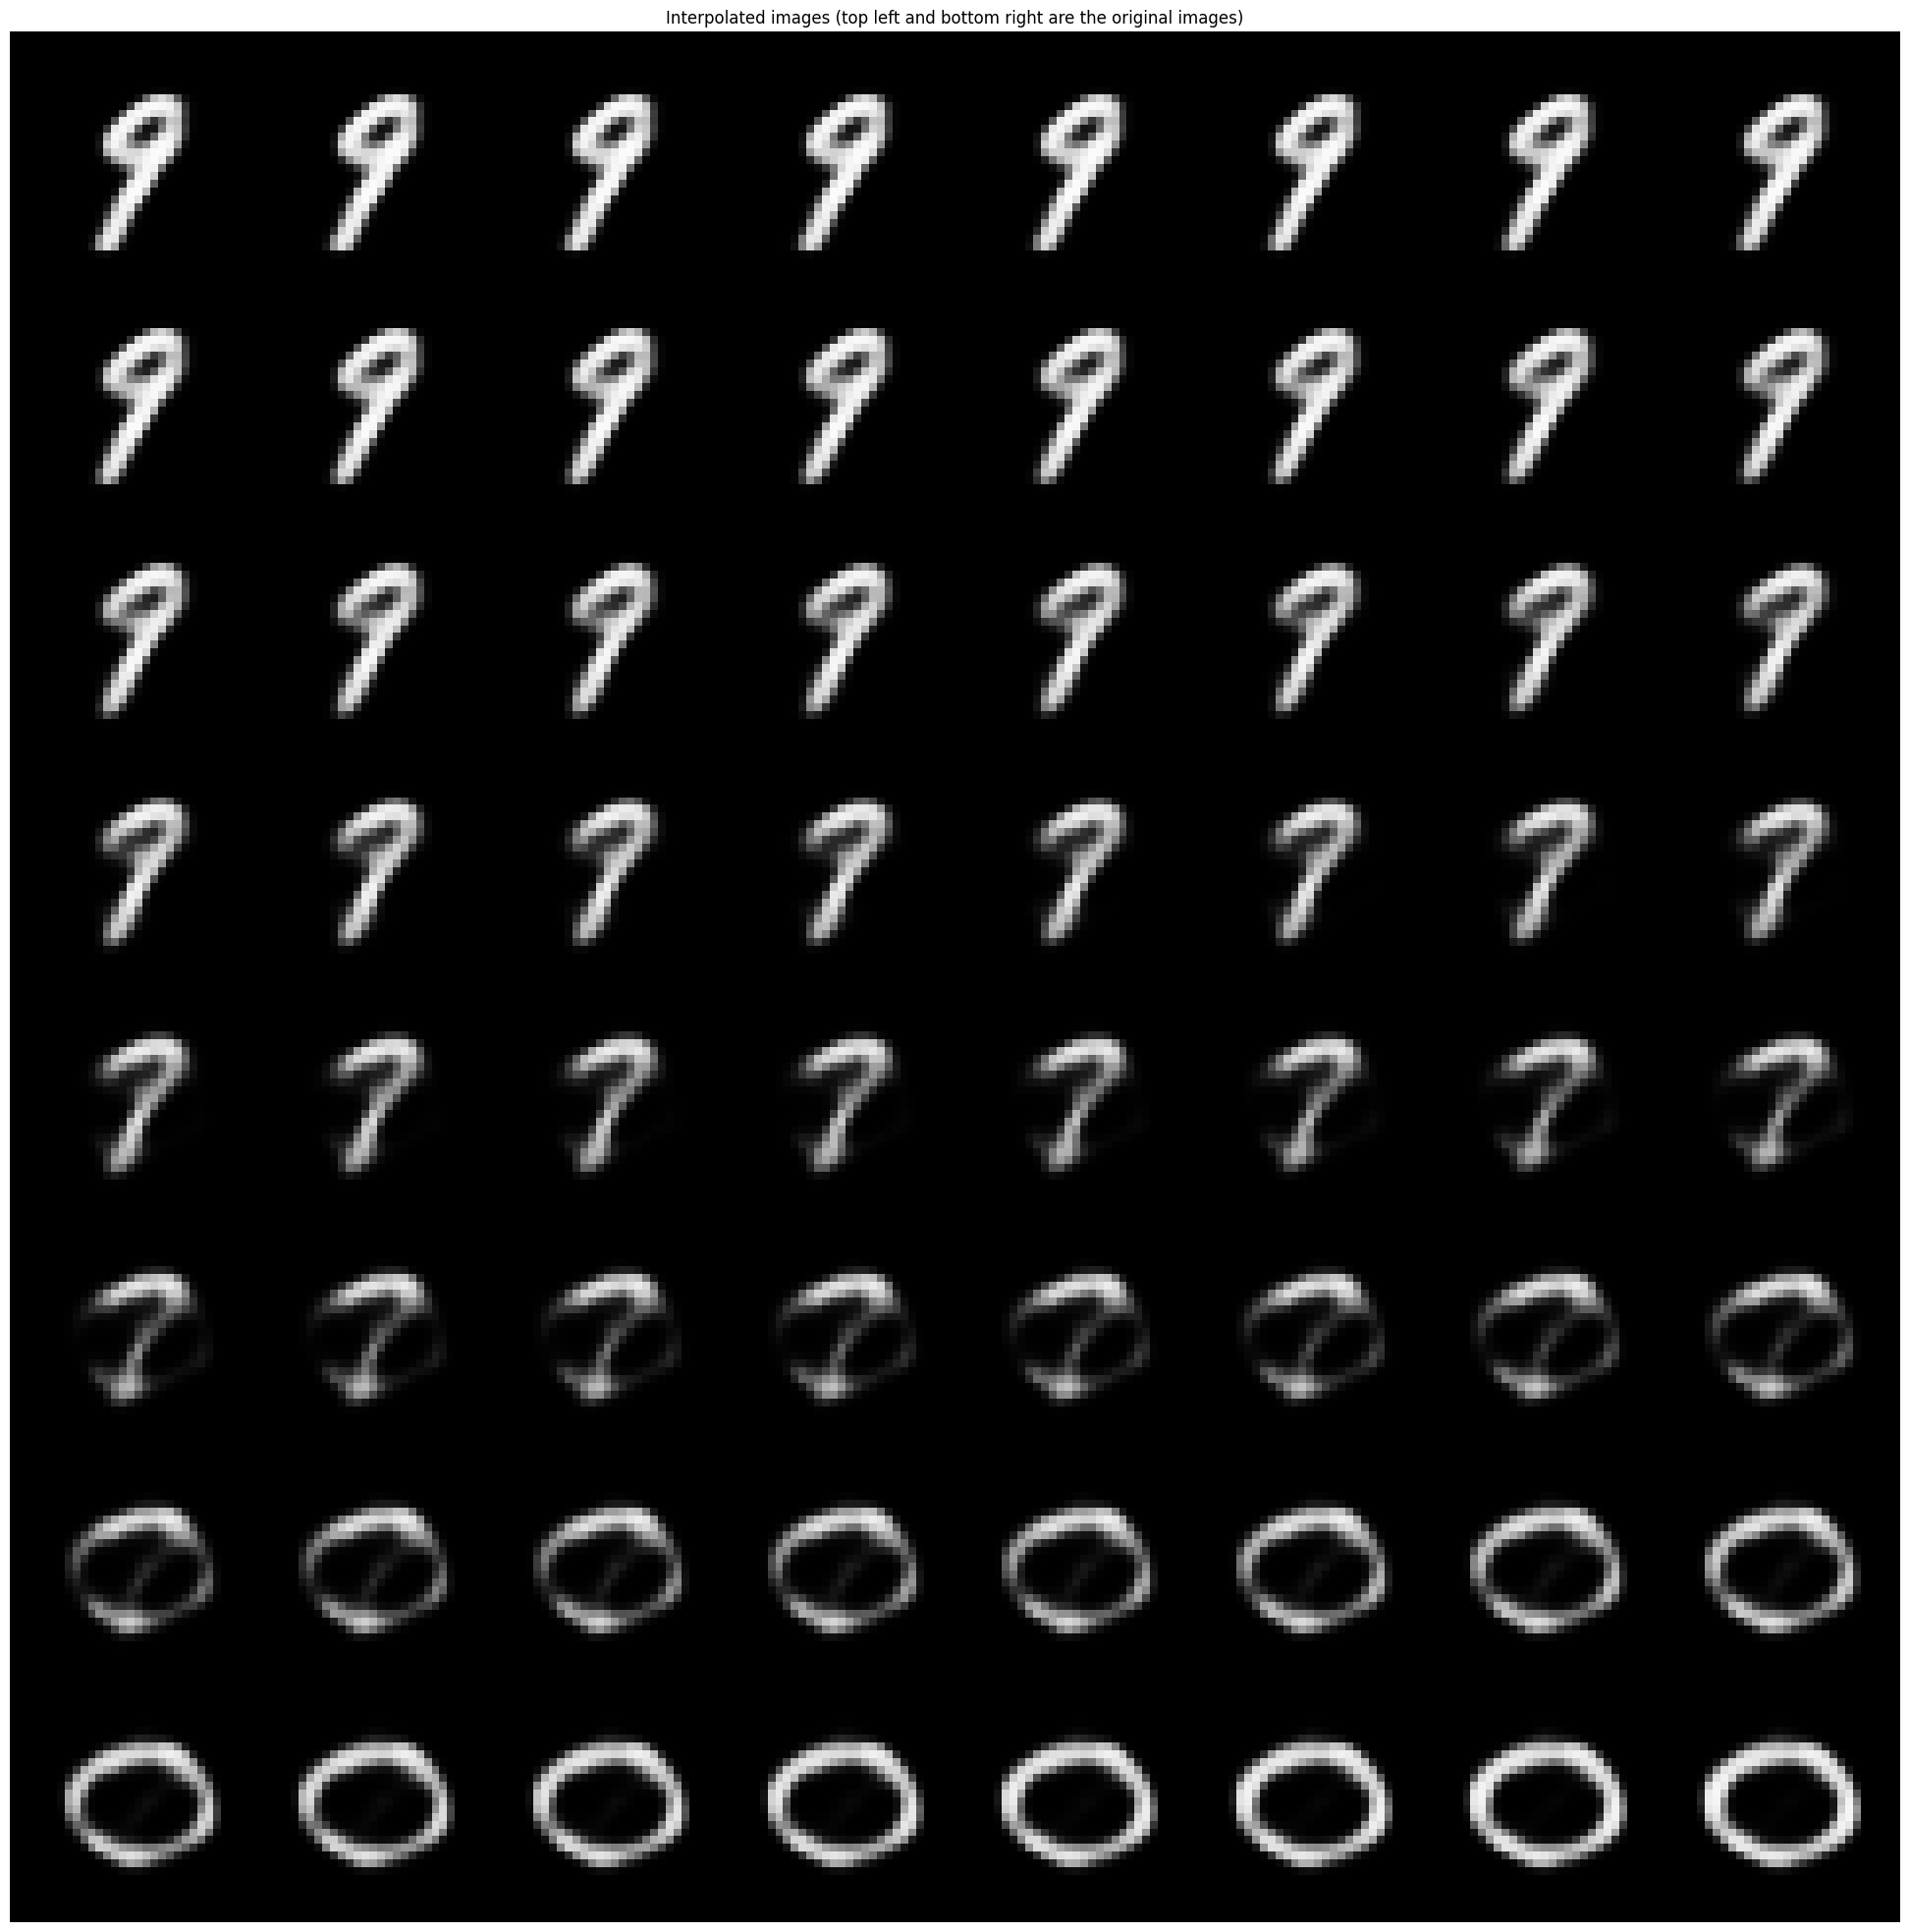

In [13]:
# We now interpolate between two images in the latent space

images = images.view(-1, input_size)
z = vae.encode(images)[0]
z1, z2 = z
num_samples = 64
z_interpolated = torch.zeros((num_samples, latent_size)).to(device)
for i in range(num_samples):
    alpha = i / (num_samples - 1)
    z_interpolated[i] = alpha * z1 + (1 - alpha) * z2

x_hat = vae.decode(z_interpolated)
x_hat = x_hat.view(-1, 1, 28, 28)

plt.figure(figsize=(25, 25))
plt.title('Interpolated images (top left and bottom right are the original images)')
show_images(x_hat, nrow=8)
plt.show()